In [1]:
import pandas as pd
import sys
from pathlib import Path
import os
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

In [2]:
# Get the current working directory (where the notebook is)
notebook_dir = Path.cwd()

# Move up to the root directory (parent of 'notebooks')
project_root = notebook_dir.parent.parent
# project_root = notebook_dir
os.chdir(project_root)


In [3]:
# from analysis.unsupervised import *
from analysis.supervised import *
from analysis.models import * 

# Load data

In [4]:
import torch
tensors_loaded = torch.load("datasets/wetransfer_direct/_meta-llamaLlama-3.2-3B-Instruct_prompt_res_activations_3011202404:14:34_rated.pkl_tensors.pt")
NEED_TO_FLIP = True # cursor told me I didn't have to flip, but if I don't, the probe results suck
if NEED_TO_FLIP:
    activations_start = tensors_loaded['data'].reshape(28, 4198, 3072)
    activations = torch.transpose(activations_start, 0, 1)
    labels_start = tensors_loaded['labels'].reshape(28, 4198)
    labels = torch.transpose(labels_start, 0, 1)
else:
    activations = tensors_loaded['data'].reshape(4198, 28, 3072)
    labels = tensors_loaded['labels'].reshape(4198, 28)

all_rows_internally_same = torch.all(torch.all(labels == labels[:,[0]], dim=1)).item()
assert all_rows_internally_same, "Labels are not internally consistent"
labels = labels[:, 0]

ADD_MEAN_LAYER = True
if ADD_MEAN_LAYER:
    # Calculate mean over layers dimension (dim=1, keepdim=True)
    mean_layer = torch.mean(activations, dim=1, keepdim=True)  

    # Concatenate mean layer to original activations
    activations_with_mean = torch.cat([activations, mean_layer], dim=1)  # New shape: (n_samples, n_layers+1, n_vector_length)
    assert (activations_with_mean[:, 5, :] == activations[:, 5, :]).all()
    activations = activations_with_mean


n_layers = activations.shape[1]
n_samples = activations.shape[0]
n_vector_length = activations.shape[2]
activations.shape, labels.shape

/var/tmp/ipykernel_924014/3014025734.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors_loaded = torch.load("datasets/wetransfer_direct/_meta-llamaLlama-3.2-3B-Inst

(torch.Size([4198, 29, 3072]), torch.Size([4198]))

In [5]:
df = pd.read_csv("datasets/wetransfer_direct/_meta-llamaLlama-3.2-3B-Instruct_prompt_res_activations_3011202404:14:34_rated.pkl_tensors.csv")

In [22]:
def train_test_split_activations(activations, labels):
    assert len(df) == len(activations)
    idx = range(len(df))
    # Randomly shuffle indices
    np.random.seed(42)
    shuffled_idx = np.random.permutation(idx)

    # Split into train/test sets (80/20 split)
    train_idx = shuffled_idx[:int(0.8 * len(idx))]
    test_idx = shuffled_idx[int(0.8 * len(idx)):]

    # Select train/test data using indices
    train_activations = activations[train_idx]
    test_activations = activations[test_idx]
    train_labels = labels[train_idx] 
    test_labels = labels[test_idx]
    return train_activations, train_labels, test_activations, test_labels

train_activations, train_labels, test_activations, test_labels =train_test_split_activations(activations, labels)

def plot_layer_transfer_accuracy_old(test_accuracies_for_plot):

    # Create figure with larger size    
    plt.figure(figsize=(12, 10))

    # Create heatmap
    sns.heatmap(test_accuracies_for_plot, 
                annot=True,  # Show numbers in cells
                fmt='.2f',   # Format numbers to 2 decimal places
                cmap='viridis',  # Color scheme
                xticklabels=list(range(n_layers-1))+["mean"],  # Layer numbers on x-axis
                yticklabels=list(range(n_layers-1))+["mean"],  # Layer numbers on y-axis
                cbar_kws={'label': 'Accuracy'})  # Colorbar label

    # Add labels and title
    plt.xlabel('Test Layer')
    plt.ylabel('Train Layer')
    plt.title(f'Cross-Layer Generalization Matrix')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Save the plot if needed
    # save_path = project_root / f"datasets/layer_transfer/cross_layer_generalization.pdf"
    # save_path.parent.mkdir(parents=True, exist_ok=True)
    save_path = "datasets/layer_transfer/cross_layer_generalization.pdf"

    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

def plot_layer_transfer_accuracy(test_accuracies_for_plot, specifier = "logistic_regression"):
    # Set style for publication-quality plot
    plt.style.use('seaborn-v0_8-paper')  # Using modern seaborn style for publication-quality plots
    # plt.style.use('seaborn-v0_8-colorblind')
    plt.rcParams.update({
        'axes.spines.top': False,
        'axes.spines.right': False,
        # Remove font family settings since Arial is not available
        'axes.labelpad': 10
    })
    
    # Create figure with publication-friendly size and DPI
    plt.figure(figsize=(10, 8), dpi=300)

    # Create heatmap with refined aesthetics
    heatmap = sns.heatmap(100*test_accuracies_for_plot,
                annot=False,  # Clean look without numbers
                # cmap='viridis',  # Changed to viridis for brighter colors
                xticklabels=[str(i) for i in list(range(n_layers-1))+["mean"]], # Convert to strings
                yticklabels=[str(i) for i in list(range(n_layers-1))+["mean"]], # Convert to strings
                square=True,  # Ensure square cells
                vmin=0.5,  # Set minimum value to 0.5
                vmax=1.0,  # Set maximum value to 1.0
                cbar_kws={
                    'label': 'Classification Accuracy',
                    'ticks': [50, 60, 70, 80, 90, 100] #[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                })

    # Adjust colorbar label size
    heatmap.collections[0].colorbar.ax.set_ylabel('Classification Accuracy (%)', fontsize=16)
    heatmap.collections[0].colorbar.ax.tick_params(labelsize=14)

    # Add publication-quality labels
    plt.xlabel('Target Layer', fontsize=16, fontweight='bold')
    plt.ylabel('Source Layer', fontsize=16, fontweight='bold')

    # Refine tick labels
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)

    # Add subtle grid for better readability
    plt.grid(False)

    # Adjust layout for perfect spacing
    plt.tight_layout()

    # Save in high quality
    save_path = f"datasets/layer_transfer/cross_layer_generalization_{specifier}"
    plt.savefig(f"{save_path}.pdf", bbox_inches='tight', dpi=300, format='pdf')
    plt.savefig(f"{save_path}.png", bbox_inches='tight', dpi=300, format='png')
    
    plt.show()


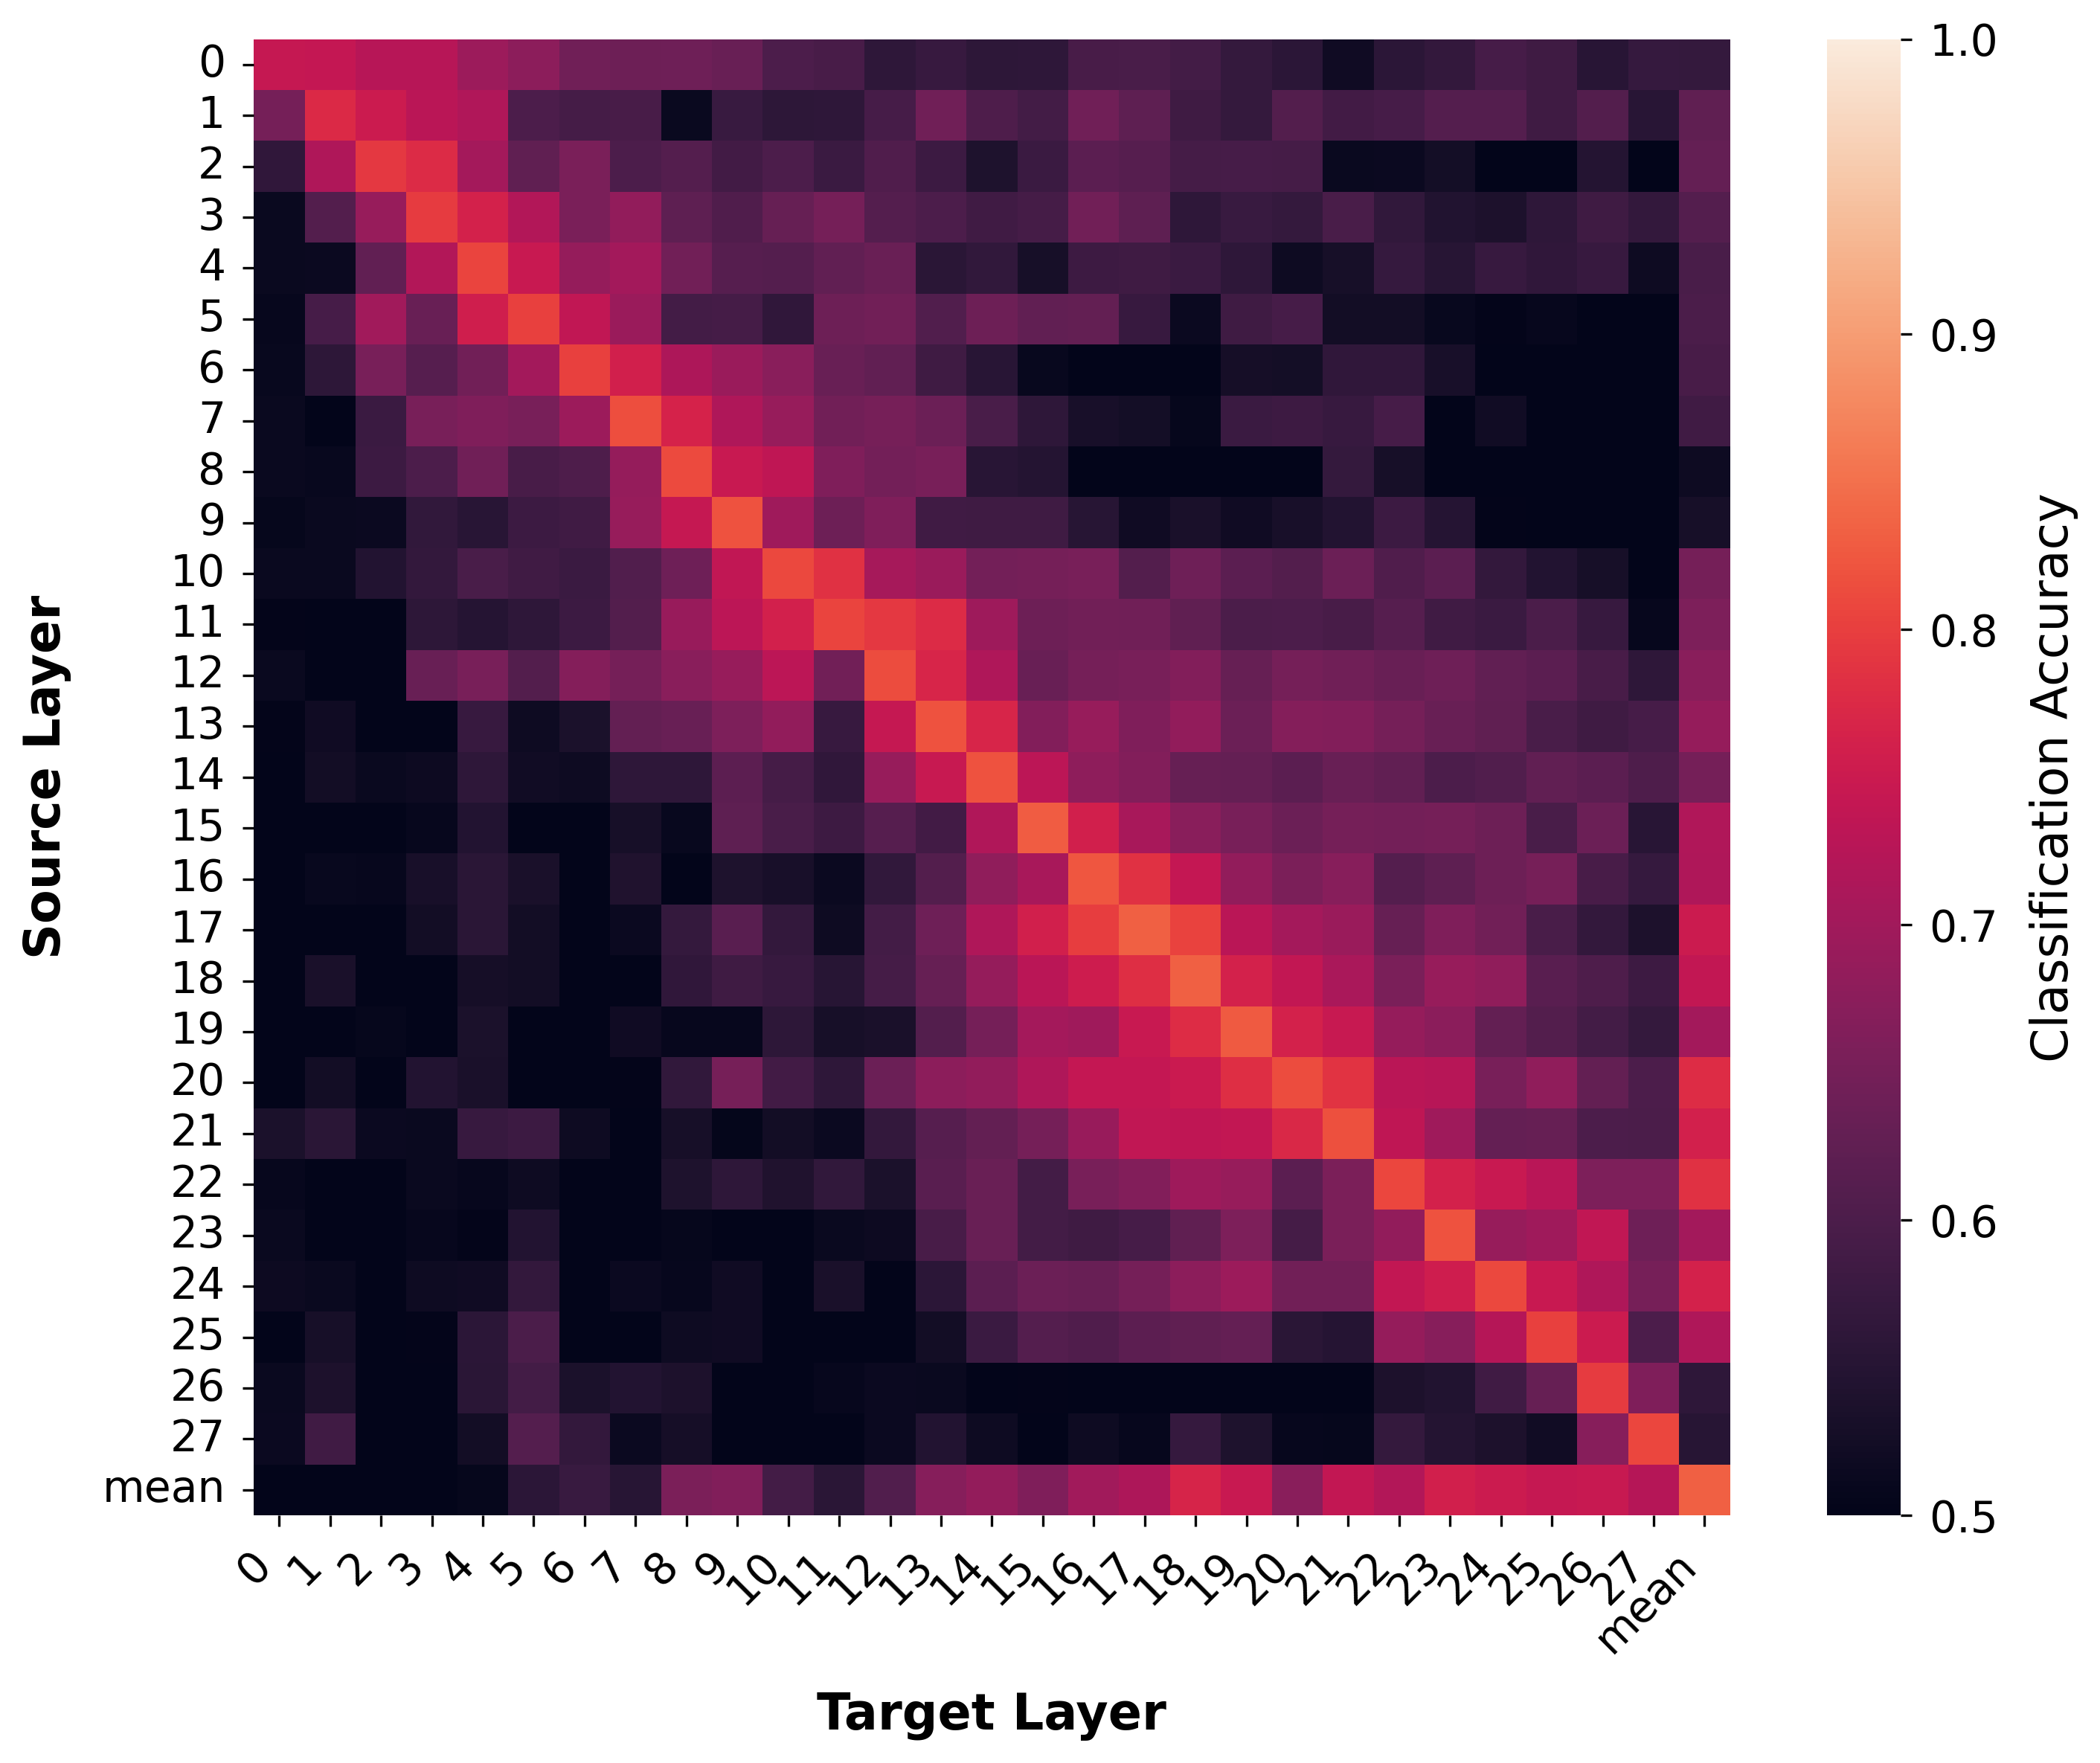

In [23]:
plot_layer_transfer_accuracy(test_accuracies_mean, specifier = "logistic_regression")

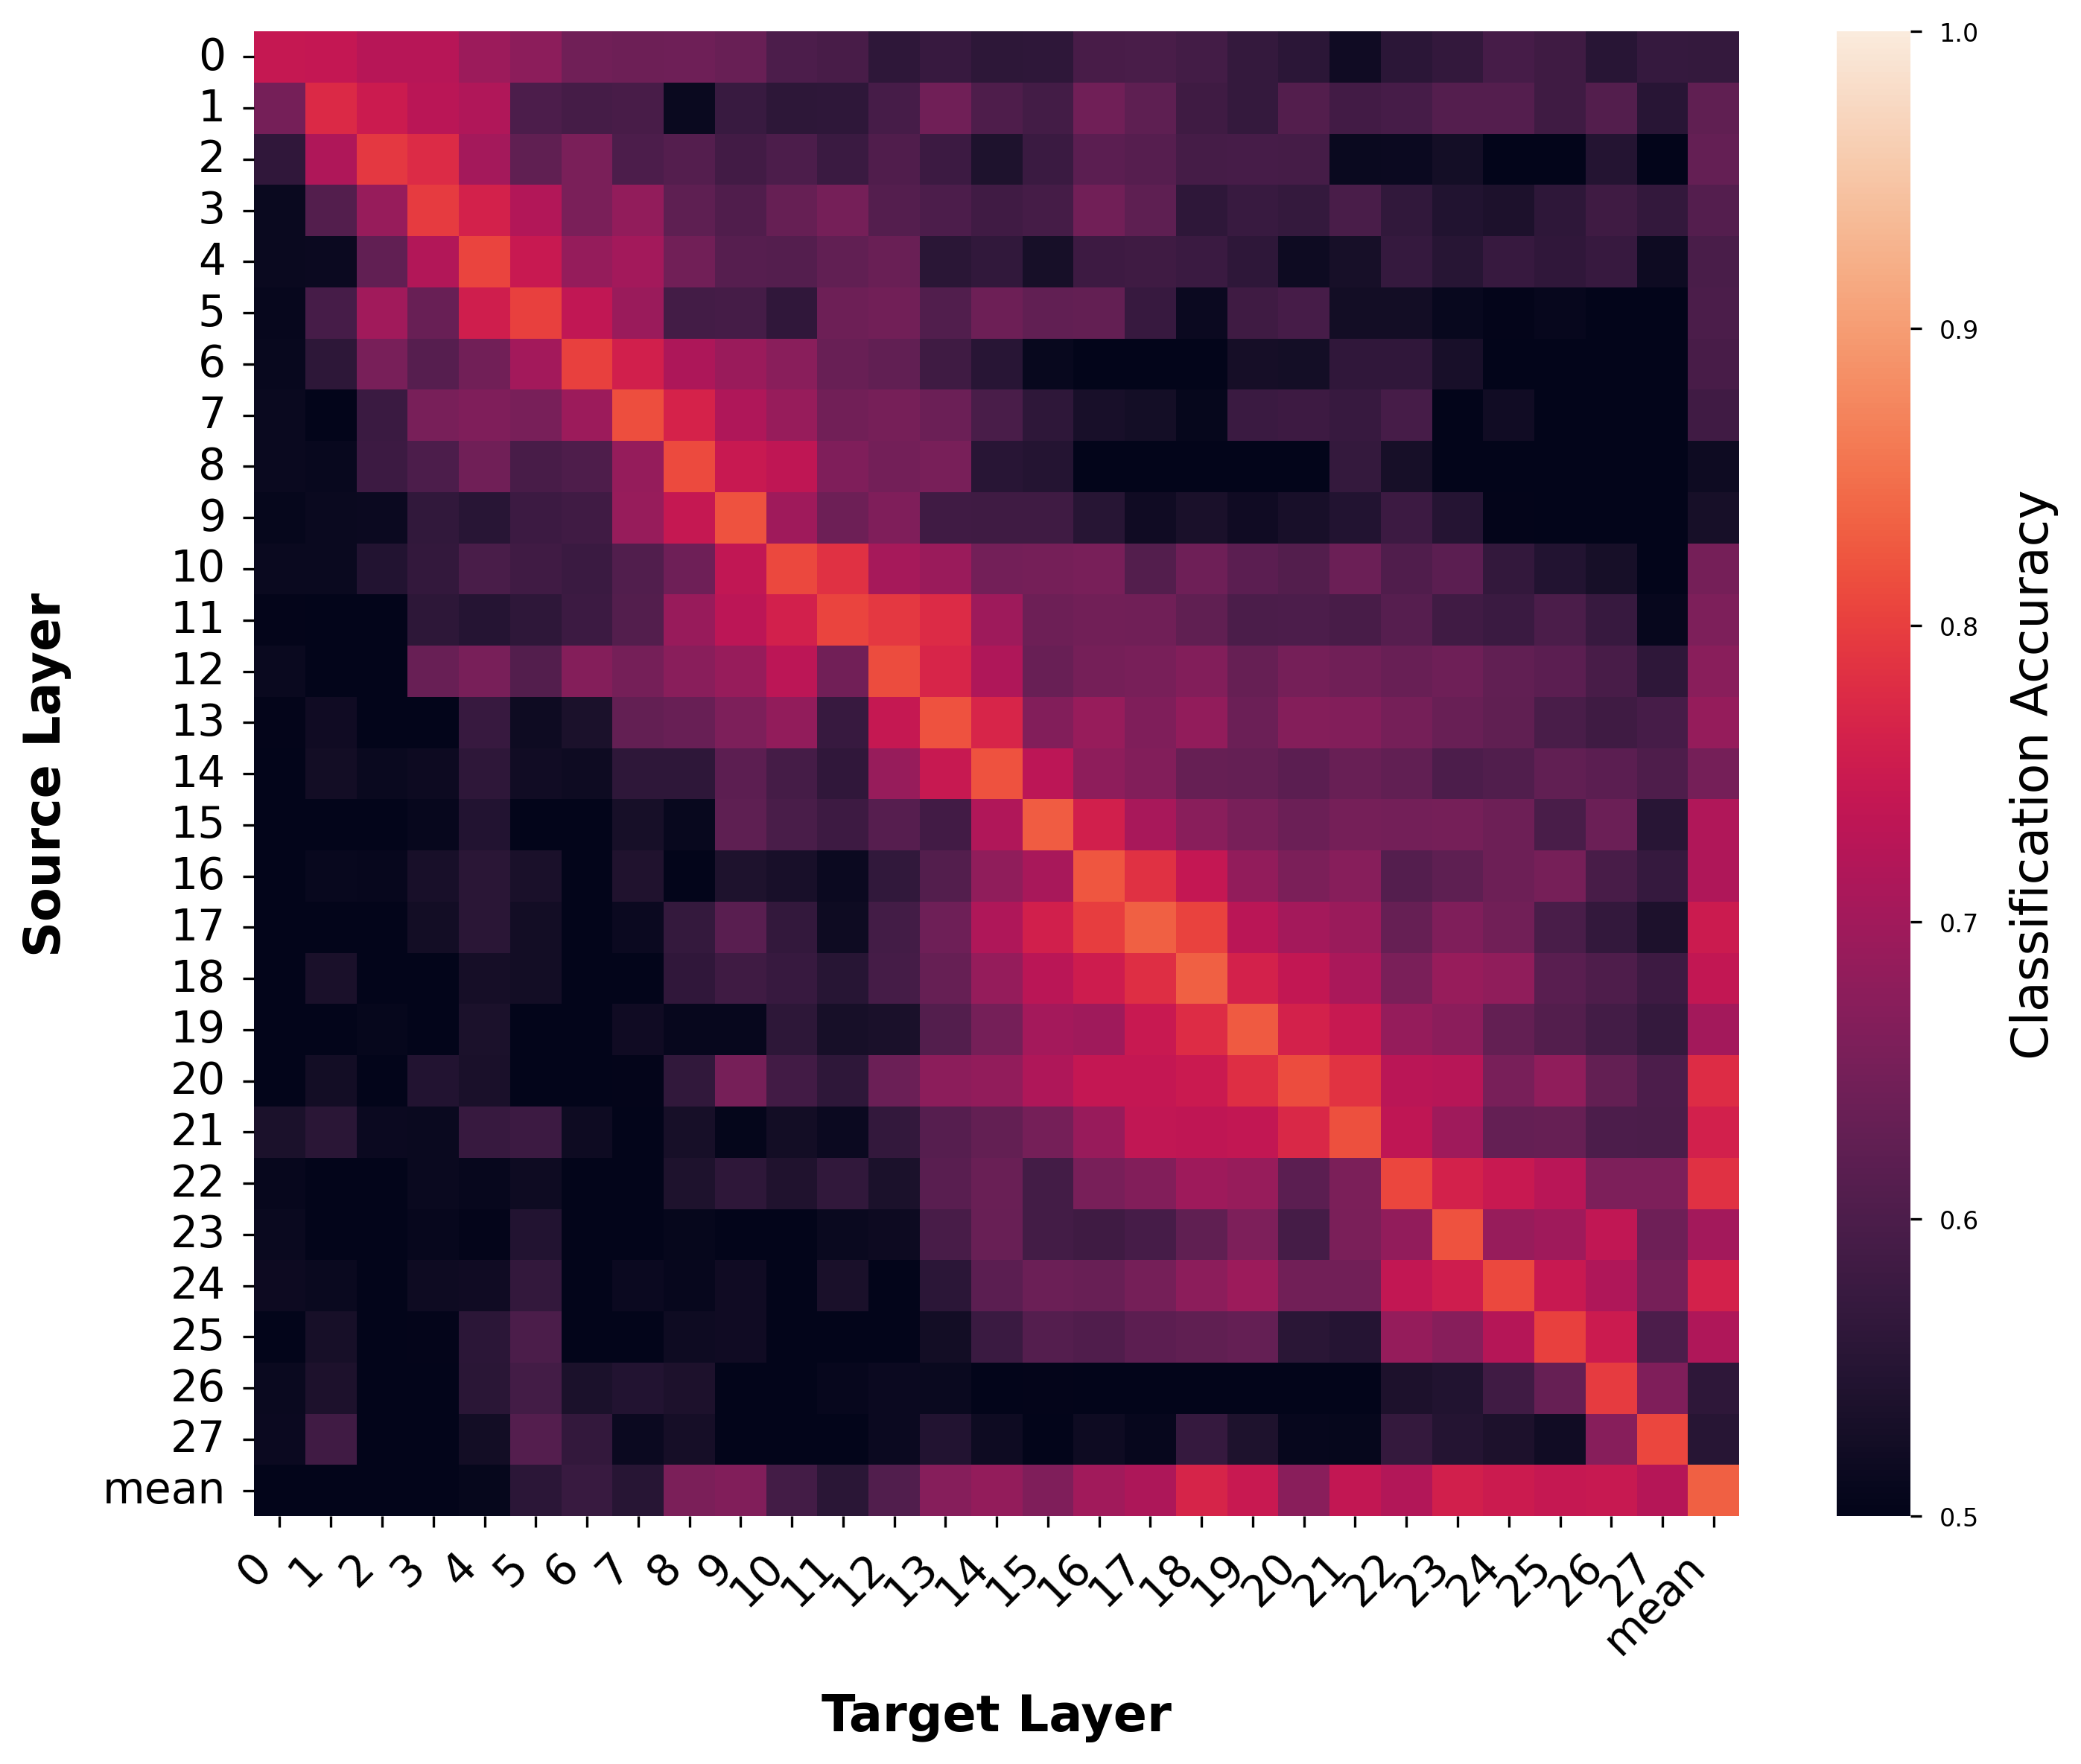

In [17]:
plot_layer_transfer_accuracy(test_accuracies_mean, specifier = "logistic_regression")

In [11]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [8]:
fname_save_template = "datasets/layer_transfer/logistic_regression_layer_accuracies_{save_id}.csv"

for save_id in range(3):  
    test_accuracies = -1*np.ones((n_layers,n_layers))
    train_accuracies = -1*np.ones(n_layers)
    for layer_train in tqdm.tqdm(range(n_layers)):
        log_model = LogisticRegression(solver='lbfgs', max_iter=1000)
        log_model.fit(train_activations[:,layer_train,:], train_labels)
        for layer_test in range(n_layers):
            test_accuracy = log_model.score(test_activations[:,layer_test,:], test_labels)
            test_accuracies[layer_train,layer_test] = test_accuracy
    np.savetxt(fname_save_template.format(save_id=save_id), test_accuracies, delimiter=",")


l_test_accuracies = []
for save_id in range(3):
    test_accuracies_i  = np.loadtxt(fname_save_template.format(save_id=save_id), delimiter=",")
    l_test_accuracies.append(test_accuracies_i)

test_accuracies_mean = np.mean(l_test_accuracies, axis=0)

plot_layer_transfer_accuracy(test_accuracies_mean, specifier = "logistic_regression")


100%|██████████| 29/29 [00:48<00:00,  1.67s/it]


OSError: 'seaborn-white' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [19]:
fname_save_template = "datasets/layer_transfer/mlp_layer_accuracies_{save_id}.csv"

for save_id in range(3):    
    test_accuracies_mlp = -1*np.ones((n_layers,n_layers))
    for layer_train in tqdm.tqdm(range(n_layers)):
        mlp = SimpleMLP(input_size=train_activations.shape[-1])
        mlp.to("cuda")
        mlp.train_MLP(train_data = train_activations[:,layer_train,:], train_labels = train_labels, num_epochs = 500)
        for layer_test in range(n_layers):
            test_accuracy, conf_matrix = mlp.get_accuracy(test_data = test_activations[:,layer_test,:], test_labels = test_labels)
            test_accuracies_mlp[layer_train,layer_test] = test_accuracy
    np.savetxt(fname_save_template.format(save_id=save_id), test_accuracies_mlp, delimiter=",")
    
l_test_accuracies = []
for save_id in range(3):
    test_accuracies_i  = np.loadtxt(fname_save_template.format(save_id=save_id), delimiter=",")
    l_test_accuracies.append(test_accuracies_i)

test_accuracies_mean = np.mean(l_test_accuracies, axis=0)

plot_layer_transfer_accuracy(test_accuracies_mean, specifier = "mlp")

  0%|          | 0/29 [00:00<?, ?it/s]/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6211
Epoch [20/500], Loss: 0.5892
Epoch [30/500], Loss: 0.5706
Epoch [40/500], Loss: 0.5584
Epoch [50/500], Loss: 0.5496
Epoch [60/500], Loss: 0.5425
Epoch [70/500], Loss: 0.5368
Epoch [80/500], Loss: 0.5319
Epoch [90/500], Loss: 0.5276
Epoch [100/500], Loss: 0.5239
Epoch [110/500], Loss: 0.5205
Epoch [120/500], Loss: 0.5174
Epoch [130/500], Loss: 0.5146
Epoch [140/500], Loss: 0.5119
Epoch [150/500], Loss: 0.5094
Epoch [160/500], Loss: 0.5071
Epoch [170/500], Loss: 0.5048
Epoch [180/500], Loss: 0.5028
Epoch [190/500], Loss: 0.5008
Epoch [200/500], Loss: 0.4990
Epoch [210/500], Loss: 0.4972
Epoch [220/500], Loss: 0.4955
Epoch [230/500], Loss: 0.4939
Epoch [240/500], Loss: 0.4923
Epoch [250/500], Loss: 0.4907
Epoch [260/500], Loss: 0.4892
Epoch [270/500], Loss: 0.4877
Epoch [280/500], Loss: 0.4863
Epoch [290/500], Loss: 0.4849
Epoch [300/500], Loss: 0.4835
Epoch [310/500], Loss: 0.4822
Epoch [320/500], Loss: 0.4809
Epoch [330/500], Loss: 0.4796
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.5966
Epoch [20/500], Loss: 0.5588
Epoch [30/500], Loss: 0.5383
Epoch [40/500], Loss: 0.5250
Epoch [50/500], Loss: 0.5158
Epoch [60/500], Loss: 0.5088
Epoch [70/500], Loss: 0.5032
Epoch [80/500], Loss: 0.4985
Epoch [90/500], Loss: 0.4946
Epoch [100/500], Loss: 0.4911
Epoch [110/500], Loss: 0.4881
Epoch [120/500], Loss: 0.4853
Epoch [130/500], Loss: 0.4828
Epoch [140/500], Loss: 0.4805
Epoch [150/500], Loss: 0.4784
Epoch [160/500], Loss: 0.4765
Epoch [170/500], Loss: 0.4747
Epoch [180/500], Loss: 0.4730
Epoch [190/500], Loss: 0.4714
Epoch [200/500], Loss: 0.4699
Epoch [210/500], Loss: 0.4685
Epoch [220/500], Loss: 0.4671
Epoch [230/500], Loss: 0.4658
Epoch [240/500], Loss: 0.4645
Epoch [250/500], Loss: 0.4633
Epoch [260/500], Loss: 0.4622
Epoch [270/500], Loss: 0.4610
Epoch [280/500], Loss: 0.4599
Epoch [290/500], Loss: 0.4588
Epoch [300/500], Loss: 0.4578
Epoch [310/500], Loss: 0.4568
Epoch [320/500], Loss: 0.4558
Epoch [330/500], Loss: 0.4548
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6520
Epoch [20/500], Loss: 0.6221
Epoch [30/500], Loss: 0.6026
Epoch [40/500], Loss: 0.5881
Epoch [50/500], Loss: 0.5769
Epoch [60/500], Loss: 0.5680
Epoch [70/500], Loss: 0.5608
Epoch [80/500], Loss: 0.5547
Epoch [90/500], Loss: 0.5494
Epoch [100/500], Loss: 0.5447
Epoch [110/500], Loss: 0.5404
Epoch [120/500], Loss: 0.5364
Epoch [130/500], Loss: 0.5326
Epoch [140/500], Loss: 0.5287
Epoch [150/500], Loss: 0.5247
Epoch [160/500], Loss: 0.5204
Epoch [170/500], Loss: 0.5131
Epoch [180/500], Loss: 0.5059
Epoch [190/500], Loss: 0.4995
Epoch [200/500], Loss: 0.4940
Epoch [210/500], Loss: 0.4894
Epoch [220/500], Loss: 0.4857
Epoch [230/500], Loss: 0.4826
Epoch [240/500], Loss: 0.4800
Epoch [250/500], Loss: 0.4777
Epoch [260/500], Loss: 0.4757
Epoch [270/500], Loss: 0.4739
Epoch [280/500], Loss: 0.4723
Epoch [290/500], Loss: 0.4708
Epoch [300/500], Loss: 0.4694
Epoch [310/500], Loss: 0.4681
Epoch [320/500], Loss: 0.4669
Epoch [330/500], Loss: 0.4657
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6226
Epoch [20/500], Loss: 0.5794
Epoch [30/500], Loss: 0.5527
Epoch [40/500], Loss: 0.5347
Epoch [50/500], Loss: 0.5215
Epoch [60/500], Loss: 0.5113
Epoch [70/500], Loss: 0.5028
Epoch [80/500], Loss: 0.4957
Epoch [90/500], Loss: 0.4895
Epoch [100/500], Loss: 0.4839
Epoch [110/500], Loss: 0.4792
Epoch [120/500], Loss: 0.4751
Epoch [130/500], Loss: 0.4714
Epoch [140/500], Loss: 0.4681
Epoch [150/500], Loss: 0.4651
Epoch [160/500], Loss: 0.4624
Epoch [170/500], Loss: 0.4599
Epoch [180/500], Loss: 0.4575
Epoch [190/500], Loss: 0.4553
Epoch [200/500], Loss: 0.4532
Epoch [210/500], Loss: 0.4512
Epoch [220/500], Loss: 0.4493
Epoch [230/500], Loss: 0.4475
Epoch [240/500], Loss: 0.4457
Epoch [250/500], Loss: 0.4441
Epoch [260/500], Loss: 0.4425
Epoch [270/500], Loss: 0.4409
Epoch [280/500], Loss: 0.4394
Epoch [290/500], Loss: 0.4380
Epoch [300/500], Loss: 0.4366
Epoch [310/500], Loss: 0.4352
Epoch [320/500], Loss: 0.4339
Epoch [330/500], Loss: 0.4326
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.5960
Epoch [20/500], Loss: 0.5531
Epoch [30/500], Loss: 0.5308
Epoch [40/500], Loss: 0.5161
Epoch [50/500], Loss: 0.5054
Epoch [60/500], Loss: 0.4970
Epoch [70/500], Loss: 0.4899
Epoch [80/500], Loss: 0.4837
Epoch [90/500], Loss: 0.4782
Epoch [100/500], Loss: 0.4733
Epoch [110/500], Loss: 0.4687
Epoch [120/500], Loss: 0.4646
Epoch [130/500], Loss: 0.4608
Epoch [140/500], Loss: 0.4573
Epoch [150/500], Loss: 0.4540
Epoch [160/500], Loss: 0.4508
Epoch [170/500], Loss: 0.4479
Epoch [180/500], Loss: 0.4450
Epoch [190/500], Loss: 0.4423
Epoch [200/500], Loss: 0.4397
Epoch [210/500], Loss: 0.4372
Epoch [220/500], Loss: 0.4348
Epoch [230/500], Loss: 0.4324
Epoch [240/500], Loss: 0.4301
Epoch [250/500], Loss: 0.4279
Epoch [260/500], Loss: 0.4257
Epoch [270/500], Loss: 0.4236
Epoch [280/500], Loss: 0.4216
Epoch [290/500], Loss: 0.4197
Epoch [300/500], Loss: 0.4178
Epoch [310/500], Loss: 0.4160
Epoch [320/500], Loss: 0.4143
Epoch [330/500], Loss: 0.4125
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6545
Epoch [20/500], Loss: 0.6279
Epoch [30/500], Loss: 0.6069
Epoch [40/500], Loss: 0.5896
Epoch [50/500], Loss: 0.5749
Epoch [60/500], Loss: 0.5620
Epoch [70/500], Loss: 0.5503
Epoch [80/500], Loss: 0.5400
Epoch [90/500], Loss: 0.5308
Epoch [100/500], Loss: 0.5227
Epoch [110/500], Loss: 0.5154
Epoch [120/500], Loss: 0.5089
Epoch [130/500], Loss: 0.5031
Epoch [140/500], Loss: 0.4979
Epoch [150/500], Loss: 0.4933
Epoch [160/500], Loss: 0.4891
Epoch [170/500], Loss: 0.4853
Epoch [180/500], Loss: 0.4818
Epoch [190/500], Loss: 0.4787
Epoch [200/500], Loss: 0.4758
Epoch [210/500], Loss: 0.4731
Epoch [220/500], Loss: 0.4706
Epoch [230/500], Loss: 0.4684
Epoch [240/500], Loss: 0.4662
Epoch [250/500], Loss: 0.4642
Epoch [260/500], Loss: 0.4623
Epoch [270/500], Loss: 0.4605
Epoch [280/500], Loss: 0.4588
Epoch [290/500], Loss: 0.4571
Epoch [300/500], Loss: 0.4555
Epoch [310/500], Loss: 0.4539
Epoch [320/500], Loss: 0.4524
Epoch [330/500], Loss: 0.4509
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.6297
Epoch [20/500], Loss: 0.5887
Epoch [30/500], Loss: 0.5633
Epoch [40/500], Loss: 0.5453
Epoch [50/500], Loss: 0.5310
Epoch [60/500], Loss: 0.5190
Epoch [70/500], Loss: 0.5085
Epoch [80/500], Loss: 0.4991
Epoch [90/500], Loss: 0.4907
Epoch [100/500], Loss: 0.4832
Epoch [110/500], Loss: 0.4763
Epoch [120/500], Loss: 0.4701
Epoch [130/500], Loss: 0.4646
Epoch [140/500], Loss: 0.4596
Epoch [150/500], Loss: 0.4551
Epoch [160/500], Loss: 0.4510
Epoch [170/500], Loss: 0.4473
Epoch [180/500], Loss: 0.4440
Epoch [190/500], Loss: 0.4409
Epoch [200/500], Loss: 0.4380
Epoch [210/500], Loss: 0.4353
Epoch [220/500], Loss: 0.4328
Epoch [230/500], Loss: 0.4303
Epoch [240/500], Loss: 0.4280
Epoch [250/500], Loss: 0.4257
Epoch [260/500], Loss: 0.4235
Epoch [270/500], Loss: 0.4213
Epoch [280/500], Loss: 0.4192
Epoch [290/500], Loss: 0.4172
Epoch [300/500], Loss: 0.4153
Epoch [310/500], Loss: 0.4134
Epoch [320/500], Loss: 0.4116
Epoch [330/500], Loss: 0.4098
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6512
Epoch [20/500], Loss: 0.6122
Epoch [30/500], Loss: 0.5853
Epoch [40/500], Loss: 0.5641
Epoch [50/500], Loss: 0.5471
Epoch [60/500], Loss: 0.5331
Epoch [70/500], Loss: 0.5215
Epoch [80/500], Loss: 0.5117
Epoch [90/500], Loss: 0.5033
Epoch [100/500], Loss: 0.4963
Epoch [110/500], Loss: 0.4903
Epoch [120/500], Loss: 0.4853
Epoch [130/500], Loss: 0.4810
Epoch [140/500], Loss: 0.4771
Epoch [150/500], Loss: 0.4737
Epoch [160/500], Loss: 0.4706
Epoch [170/500], Loss: 0.4677
Epoch [180/500], Loss: 0.4649
Epoch [190/500], Loss: 0.4623
Epoch [200/500], Loss: 0.4598
Epoch [210/500], Loss: 0.4573
Epoch [220/500], Loss: 0.4549
Epoch [230/500], Loss: 0.4526
Epoch [240/500], Loss: 0.4504
Epoch [250/500], Loss: 0.4482
Epoch [260/500], Loss: 0.4461
Epoch [270/500], Loss: 0.4440
Epoch [280/500], Loss: 0.4420
Epoch [290/500], Loss: 0.4401
Epoch [300/500], Loss: 0.4381
Epoch [310/500], Loss: 0.4361
Epoch [320/500], Loss: 0.4341
Epoch [330/500], Loss: 0.4322
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6242
Epoch [20/500], Loss: 0.5770
Epoch [30/500], Loss: 0.5517
Epoch [40/500], Loss: 0.5361
Epoch [50/500], Loss: 0.5251
Epoch [60/500], Loss: 0.5166
Epoch [70/500], Loss: 0.5095
Epoch [80/500], Loss: 0.5033
Epoch [90/500], Loss: 0.4977
Epoch [100/500], Loss: 0.4927
Epoch [110/500], Loss: 0.4881
Epoch [120/500], Loss: 0.4837
Epoch [130/500], Loss: 0.4796
Epoch [140/500], Loss: 0.4758
Epoch [150/500], Loss: 0.4723
Epoch [160/500], Loss: 0.4690
Epoch [170/500], Loss: 0.4657
Epoch [180/500], Loss: 0.4626
Epoch [190/500], Loss: 0.4596
Epoch [200/500], Loss: 0.4568
Epoch [210/500], Loss: 0.4541
Epoch [220/500], Loss: 0.4515
Epoch [230/500], Loss: 0.4489
Epoch [240/500], Loss: 0.4465
Epoch [250/500], Loss: 0.4442
Epoch [260/500], Loss: 0.4419
Epoch [270/500], Loss: 0.4397
Epoch [280/500], Loss: 0.4375
Epoch [290/500], Loss: 0.4354
Epoch [300/500], Loss: 0.4334
Epoch [310/500], Loss: 0.4314
Epoch [320/500], Loss: 0.4295
Epoch [330/500], Loss: 0.4276
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.6321
Epoch [20/500], Loss: 0.5884
Epoch [30/500], Loss: 0.5592
Epoch [40/500], Loss: 0.5382
Epoch [50/500], Loss: 0.5226
Epoch [60/500], Loss: 0.5107
Epoch [70/500], Loss: 0.5012
Epoch [80/500], Loss: 0.4938
Epoch [90/500], Loss: 0.4879
Epoch [100/500], Loss: 0.4831
Epoch [110/500], Loss: 0.4791
Epoch [120/500], Loss: 0.4756
Epoch [130/500], Loss: 0.4726
Epoch [140/500], Loss: 0.4699
Epoch [150/500], Loss: 0.4674
Epoch [160/500], Loss: 0.4651
Epoch [170/500], Loss: 0.4629
Epoch [180/500], Loss: 0.4607
Epoch [190/500], Loss: 0.4587
Epoch [200/500], Loss: 0.4567
Epoch [210/500], Loss: 0.4547
Epoch [220/500], Loss: 0.4528
Epoch [230/500], Loss: 0.4509
Epoch [240/500], Loss: 0.4490
Epoch [250/500], Loss: 0.4472
Epoch [260/500], Loss: 0.4455
Epoch [270/500], Loss: 0.4437
Epoch [280/500], Loss: 0.4420
Epoch [290/500], Loss: 0.4403
Epoch [300/500], Loss: 0.4387
Epoch [310/500], Loss: 0.4370
Epoch [320/500], Loss: 0.4353
Epoch [330/500], Loss: 0.4336
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6310
Epoch [20/500], Loss: 0.5816
Epoch [30/500], Loss: 0.5490
Epoch [40/500], Loss: 0.5267
Epoch [50/500], Loss: 0.5102
Epoch [60/500], Loss: 0.4974
Epoch [70/500], Loss: 0.4870
Epoch [80/500], Loss: 0.4785
Epoch [90/500], Loss: 0.4714
Epoch [100/500], Loss: 0.4653
Epoch [110/500], Loss: 0.4601
Epoch [120/500], Loss: 0.4554
Epoch [130/500], Loss: 0.4511
Epoch [140/500], Loss: 0.4472
Epoch [150/500], Loss: 0.4435
Epoch [160/500], Loss: 0.4401
Epoch [170/500], Loss: 0.4369
Epoch [180/500], Loss: 0.4339
Epoch [190/500], Loss: 0.4311
Epoch [200/500], Loss: 0.4285
Epoch [210/500], Loss: 0.4260
Epoch [220/500], Loss: 0.4236
Epoch [230/500], Loss: 0.4213
Epoch [240/500], Loss: 0.4191
Epoch [250/500], Loss: 0.4170
Epoch [260/500], Loss: 0.4150
Epoch [270/500], Loss: 0.4130
Epoch [280/500], Loss: 0.4111
Epoch [290/500], Loss: 0.4093
Epoch [300/500], Loss: 0.4075
Epoch [310/500], Loss: 0.4058
Epoch [320/500], Loss: 0.4041
Epoch [330/500], Loss: 0.4024
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.6240
Epoch [20/500], Loss: 0.5832
Epoch [30/500], Loss: 0.5562
Epoch [40/500], Loss: 0.5365
Epoch [50/500], Loss: 0.5213
Epoch [60/500], Loss: 0.5093
Epoch [70/500], Loss: 0.4994
Epoch [80/500], Loss: 0.4912
Epoch [90/500], Loss: 0.4843
Epoch [100/500], Loss: 0.4785
Epoch [110/500], Loss: 0.4734
Epoch [120/500], Loss: 0.4690
Epoch [130/500], Loss: 0.4650
Epoch [140/500], Loss: 0.4615
Epoch [150/500], Loss: 0.4583
Epoch [160/500], Loss: 0.4553
Epoch [170/500], Loss: 0.4525
Epoch [180/500], Loss: 0.4500
Epoch [190/500], Loss: 0.4476
Epoch [200/500], Loss: 0.4453
Epoch [210/500], Loss: 0.4431
Epoch [220/500], Loss: 0.4409
Epoch [230/500], Loss: 0.4388
Epoch [240/500], Loss: 0.4368
Epoch [250/500], Loss: 0.4348
Epoch [260/500], Loss: 0.4328
Epoch [270/500], Loss: 0.4309
Epoch [280/500], Loss: 0.4290
Epoch [290/500], Loss: 0.4270
Epoch [300/500], Loss: 0.4252
Epoch [310/500], Loss: 0.4233
Epoch [320/500], Loss: 0.4215
Epoch [330/500], Loss: 0.4197
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6170
Epoch [20/500], Loss: 0.5645
Epoch [30/500], Loss: 0.5334
Epoch [40/500], Loss: 0.5134
Epoch [50/500], Loss: 0.4994
Epoch [60/500], Loss: 0.4888
Epoch [70/500], Loss: 0.4804
Epoch [80/500], Loss: 0.4734
Epoch [90/500], Loss: 0.4674
Epoch [100/500], Loss: 0.4622
Epoch [110/500], Loss: 0.4574
Epoch [120/500], Loss: 0.4531
Epoch [130/500], Loss: 0.4493
Epoch [140/500], Loss: 0.4457
Epoch [150/500], Loss: 0.4423
Epoch [160/500], Loss: 0.4391
Epoch [170/500], Loss: 0.4360
Epoch [180/500], Loss: 0.4331
Epoch [190/500], Loss: 0.4303
Epoch [200/500], Loss: 0.4275
Epoch [210/500], Loss: 0.4249
Epoch [220/500], Loss: 0.4223
Epoch [230/500], Loss: 0.4197
Epoch [240/500], Loss: 0.4172
Epoch [250/500], Loss: 0.4148
Epoch [260/500], Loss: 0.4123
Epoch [270/500], Loss: 0.4100
Epoch [280/500], Loss: 0.4077
Epoch [290/500], Loss: 0.4055
Epoch [300/500], Loss: 0.4034
Epoch [310/500], Loss: 0.4013
Epoch [320/500], Loss: 0.3993
Epoch [330/500], Loss: 0.3974
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6502
Epoch [20/500], Loss: 0.6185
Epoch [30/500], Loss: 0.5933
Epoch [40/500], Loss: 0.5717
Epoch [50/500], Loss: 0.5530
Epoch [60/500], Loss: 0.5368
Epoch [70/500], Loss: 0.5230
Epoch [80/500], Loss: 0.5111
Epoch [90/500], Loss: 0.5010
Epoch [100/500], Loss: 0.4924
Epoch [110/500], Loss: 0.4850
Epoch [120/500], Loss: 0.4784
Epoch [130/500], Loss: 0.4727
Epoch [140/500], Loss: 0.4677
Epoch [150/500], Loss: 0.4631
Epoch [160/500], Loss: 0.4590
Epoch [170/500], Loss: 0.4553
Epoch [180/500], Loss: 0.4519
Epoch [190/500], Loss: 0.4486
Epoch [200/500], Loss: 0.4455
Epoch [210/500], Loss: 0.4425
Epoch [220/500], Loss: 0.4397
Epoch [230/500], Loss: 0.4368
Epoch [240/500], Loss: 0.4340
Epoch [250/500], Loss: 0.4314
Epoch [260/500], Loss: 0.4288
Epoch [270/500], Loss: 0.4263
Epoch [280/500], Loss: 0.4240
Epoch [290/500], Loss: 0.4217
Epoch [300/500], Loss: 0.4194
Epoch [310/500], Loss: 0.4173
Epoch [320/500], Loss: 0.4152
Epoch [330/500], Loss: 0.4131
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6115
Epoch [20/500], Loss: 0.5667
Epoch [30/500], Loss: 0.5400
Epoch [40/500], Loss: 0.5210
Epoch [50/500], Loss: 0.5069
Epoch [60/500], Loss: 0.4956
Epoch [70/500], Loss: 0.4860
Epoch [80/500], Loss: 0.4776
Epoch [90/500], Loss: 0.4700
Epoch [100/500], Loss: 0.4630
Epoch [110/500], Loss: 0.4567
Epoch [120/500], Loss: 0.4511
Epoch [130/500], Loss: 0.4460
Epoch [140/500], Loss: 0.4414
Epoch [150/500], Loss: 0.4371
Epoch [160/500], Loss: 0.4333
Epoch [170/500], Loss: 0.4298
Epoch [180/500], Loss: 0.4264
Epoch [190/500], Loss: 0.4234
Epoch [200/500], Loss: 0.4205
Epoch [210/500], Loss: 0.4178
Epoch [220/500], Loss: 0.4152
Epoch [230/500], Loss: 0.4128
Epoch [240/500], Loss: 0.4105
Epoch [250/500], Loss: 0.4084
Epoch [260/500], Loss: 0.4063
Epoch [270/500], Loss: 0.4043
Epoch [280/500], Loss: 0.4023
Epoch [290/500], Loss: 0.4004
Epoch [300/500], Loss: 0.3986
Epoch [310/500], Loss: 0.3968
Epoch [320/500], Loss: 0.3950
Epoch [330/500], Loss: 0.3933
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.6310
Epoch [20/500], Loss: 0.5942
Epoch [30/500], Loss: 0.5673
Epoch [40/500], Loss: 0.5457
Epoch [50/500], Loss: 0.5276
Epoch [60/500], Loss: 0.5124
Epoch [70/500], Loss: 0.4996
Epoch [80/500], Loss: 0.4888
Epoch [90/500], Loss: 0.4795
Epoch [100/500], Loss: 0.4714
Epoch [110/500], Loss: 0.4642
Epoch [120/500], Loss: 0.4579
Epoch [130/500], Loss: 0.4521
Epoch [140/500], Loss: 0.4470
Epoch [150/500], Loss: 0.4422
Epoch [160/500], Loss: 0.4379
Epoch [170/500], Loss: 0.4337
Epoch [180/500], Loss: 0.4298
Epoch [190/500], Loss: 0.4262
Epoch [200/500], Loss: 0.4227
Epoch [210/500], Loss: 0.4195
Epoch [220/500], Loss: 0.4164
Epoch [230/500], Loss: 0.4135
Epoch [240/500], Loss: 0.4107
Epoch [250/500], Loss: 0.4080
Epoch [260/500], Loss: 0.4054
Epoch [270/500], Loss: 0.4029
Epoch [280/500], Loss: 0.4006
Epoch [290/500], Loss: 0.3983
Epoch [300/500], Loss: 0.3961
Epoch [310/500], Loss: 0.3940
Epoch [320/500], Loss: 0.3920
Epoch [330/500], Loss: 0.3901
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.6183
Epoch [20/500], Loss: 0.5728
Epoch [30/500], Loss: 0.5430
Epoch [40/500], Loss: 0.5218
Epoch [50/500], Loss: 0.5062
Epoch [60/500], Loss: 0.4942
Epoch [70/500], Loss: 0.4845
Epoch [80/500], Loss: 0.4764
Epoch [90/500], Loss: 0.4695
Epoch [100/500], Loss: 0.4636
Epoch [110/500], Loss: 0.4582
Epoch [120/500], Loss: 0.4532
Epoch [130/500], Loss: 0.4487
Epoch [140/500], Loss: 0.4446
Epoch [150/500], Loss: 0.4407
Epoch [160/500], Loss: 0.4370
Epoch [170/500], Loss: 0.4335
Epoch [180/500], Loss: 0.4302
Epoch [190/500], Loss: 0.4270
Epoch [200/500], Loss: 0.4240
Epoch [210/500], Loss: 0.4211
Epoch [220/500], Loss: 0.4183
Epoch [230/500], Loss: 0.4157
Epoch [240/500], Loss: 0.4132
Epoch [250/500], Loss: 0.4107
Epoch [260/500], Loss: 0.4083
Epoch [270/500], Loss: 0.4060
Epoch [280/500], Loss: 0.4037
Epoch [290/500], Loss: 0.4016
Epoch [300/500], Loss: 0.3995
Epoch [310/500], Loss: 0.3975
Epoch [320/500], Loss: 0.3956
Epoch [330/500], Loss: 0.3937
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6453
Epoch [20/500], Loss: 0.6047
Epoch [30/500], Loss: 0.5732
Epoch [40/500], Loss: 0.5466
Epoch [50/500], Loss: 0.5257
Epoch [60/500], Loss: 0.5094
Epoch [70/500], Loss: 0.4962
Epoch [80/500], Loss: 0.4854
Epoch [90/500], Loss: 0.4762
Epoch [100/500], Loss: 0.4684
Epoch [110/500], Loss: 0.4617
Epoch [120/500], Loss: 0.4558
Epoch [130/500], Loss: 0.4506
Epoch [140/500], Loss: 0.4460
Epoch [150/500], Loss: 0.4418
Epoch [160/500], Loss: 0.4380
Epoch [170/500], Loss: 0.4344
Epoch [180/500], Loss: 0.4309
Epoch [190/500], Loss: 0.4277
Epoch [200/500], Loss: 0.4245
Epoch [210/500], Loss: 0.4215
Epoch [220/500], Loss: 0.4187
Epoch [230/500], Loss: 0.4157
Epoch [240/500], Loss: 0.4129
Epoch [250/500], Loss: 0.4103
Epoch [260/500], Loss: 0.4077
Epoch [270/500], Loss: 0.4052
Epoch [280/500], Loss: 0.4027
Epoch [290/500], Loss: 0.4004
Epoch [300/500], Loss: 0.3981
Epoch [310/500], Loss: 0.3960
Epoch [320/500], Loss: 0.3938
Epoch [330/500], Loss: 0.3918
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6340
Epoch [20/500], Loss: 0.5932
Epoch [30/500], Loss: 0.5689
Epoch [40/500], Loss: 0.5506
Epoch [50/500], Loss: 0.5357
Epoch [60/500], Loss: 0.5230
Epoch [70/500], Loss: 0.5117
Epoch [80/500], Loss: 0.5015
Epoch [90/500], Loss: 0.4919
Epoch [100/500], Loss: 0.4827
Epoch [110/500], Loss: 0.4739
Epoch [120/500], Loss: 0.4652
Epoch [130/500], Loss: 0.4569
Epoch [140/500], Loss: 0.4491
Epoch [150/500], Loss: 0.4418
Epoch [160/500], Loss: 0.4352
Epoch [170/500], Loss: 0.4291
Epoch [180/500], Loss: 0.4237
Epoch [190/500], Loss: 0.4188
Epoch [200/500], Loss: 0.4142
Epoch [210/500], Loss: 0.4099
Epoch [220/500], Loss: 0.4059
Epoch [230/500], Loss: 0.4023
Epoch [240/500], Loss: 0.3990
Epoch [250/500], Loss: 0.3959
Epoch [260/500], Loss: 0.3931
Epoch [270/500], Loss: 0.3904
Epoch [280/500], Loss: 0.3879
Epoch [290/500], Loss: 0.3854
Epoch [300/500], Loss: 0.3831
Epoch [310/500], Loss: 0.3809
Epoch [320/500], Loss: 0.3787
Epoch [330/500], Loss: 0.3766
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6460
Epoch [20/500], Loss: 0.6086
Epoch [30/500], Loss: 0.5836
Epoch [40/500], Loss: 0.5638
Epoch [50/500], Loss: 0.5472
Epoch [60/500], Loss: 0.5325
Epoch [70/500], Loss: 0.5194
Epoch [80/500], Loss: 0.5078
Epoch [90/500], Loss: 0.4973
Epoch [100/500], Loss: 0.4878
Epoch [110/500], Loss: 0.4793
Epoch [120/500], Loss: 0.4717
Epoch [130/500], Loss: 0.4648
Epoch [140/500], Loss: 0.4585
Epoch [150/500], Loss: 0.4528
Epoch [160/500], Loss: 0.4476
Epoch [170/500], Loss: 0.4427
Epoch [180/500], Loss: 0.4382
Epoch [190/500], Loss: 0.4341
Epoch [200/500], Loss: 0.4303
Epoch [210/500], Loss: 0.4268
Epoch [220/500], Loss: 0.4233
Epoch [230/500], Loss: 0.4200
Epoch [240/500], Loss: 0.4169
Epoch [250/500], Loss: 0.4138
Epoch [260/500], Loss: 0.4109
Epoch [270/500], Loss: 0.4079
Epoch [280/500], Loss: 0.4050
Epoch [290/500], Loss: 0.4024
Epoch [300/500], Loss: 0.3998
Epoch [310/500], Loss: 0.3974
Epoch [320/500], Loss: 0.3950
Epoch [330/500], Loss: 0.3928
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.6248
Epoch [20/500], Loss: 0.5827
Epoch [30/500], Loss: 0.5535
Epoch [40/500], Loss: 0.5306
Epoch [50/500], Loss: 0.5121
Epoch [60/500], Loss: 0.4967
Epoch [70/500], Loss: 0.4838
Epoch [80/500], Loss: 0.4727
Epoch [90/500], Loss: 0.4632
Epoch [100/500], Loss: 0.4549
Epoch [110/500], Loss: 0.4476
Epoch [120/500], Loss: 0.4409
Epoch [130/500], Loss: 0.4350
Epoch [140/500], Loss: 0.4296
Epoch [150/500], Loss: 0.4247
Epoch [160/500], Loss: 0.4203
Epoch [170/500], Loss: 0.4162
Epoch [180/500], Loss: 0.4124
Epoch [190/500], Loss: 0.4087
Epoch [200/500], Loss: 0.4052
Epoch [210/500], Loss: 0.4019
Epoch [220/500], Loss: 0.3987
Epoch [230/500], Loss: 0.3958
Epoch [240/500], Loss: 0.3930
Epoch [250/500], Loss: 0.3903
Epoch [260/500], Loss: 0.3877
Epoch [270/500], Loss: 0.3852
Epoch [280/500], Loss: 0.3827
Epoch [290/500], Loss: 0.3804
Epoch [300/500], Loss: 0.3781
Epoch [310/500], Loss: 0.3759
Epoch [320/500], Loss: 0.3738
Epoch [330/500], Loss: 0.3718
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6615
Epoch [20/500], Loss: 0.6331
Epoch [30/500], Loss: 0.6117
Epoch [40/500], Loss: 0.5935
Epoch [50/500], Loss: 0.5773
Epoch [60/500], Loss: 0.5625
Epoch [70/500], Loss: 0.5488
Epoch [80/500], Loss: 0.5360
Epoch [90/500], Loss: 0.5242
Epoch [100/500], Loss: 0.5132
Epoch [110/500], Loss: 0.5032
Epoch [120/500], Loss: 0.4941
Epoch [130/500], Loss: 0.4858
Epoch [140/500], Loss: 0.4781
Epoch [150/500], Loss: 0.4712
Epoch [160/500], Loss: 0.4649
Epoch [170/500], Loss: 0.4591
Epoch [180/500], Loss: 0.4538
Epoch [190/500], Loss: 0.4489
Epoch [200/500], Loss: 0.4444
Epoch [210/500], Loss: 0.4402
Epoch [220/500], Loss: 0.4363
Epoch [230/500], Loss: 0.4326
Epoch [240/500], Loss: 0.4290
Epoch [250/500], Loss: 0.4257
Epoch [260/500], Loss: 0.4226
Epoch [270/500], Loss: 0.4196
Epoch [280/500], Loss: 0.4167
Epoch [290/500], Loss: 0.4139
Epoch [300/500], Loss: 0.4111
Epoch [310/500], Loss: 0.4085
Epoch [320/500], Loss: 0.4059
Epoch [330/500], Loss: 0.4034
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6843
Epoch [20/500], Loss: 0.6581
Epoch [30/500], Loss: 0.6350
Epoch [40/500], Loss: 0.6126
Epoch [50/500], Loss: 0.5929
Epoch [60/500], Loss: 0.5758
Epoch [70/500], Loss: 0.5611
Epoch [80/500], Loss: 0.5485
Epoch [90/500], Loss: 0.5377
Epoch [100/500], Loss: 0.5284
Epoch [110/500], Loss: 0.5202
Epoch [120/500], Loss: 0.5129
Epoch [130/500], Loss: 0.5062
Epoch [140/500], Loss: 0.5001
Epoch [150/500], Loss: 0.4944
Epoch [160/500], Loss: 0.4890
Epoch [170/500], Loss: 0.4839
Epoch [180/500], Loss: 0.4790
Epoch [190/500], Loss: 0.4741
Epoch [200/500], Loss: 0.4696
Epoch [210/500], Loss: 0.4653
Epoch [220/500], Loss: 0.4611
Epoch [230/500], Loss: 0.4571
Epoch [240/500], Loss: 0.4533
Epoch [250/500], Loss: 0.4497
Epoch [260/500], Loss: 0.4463
Epoch [270/500], Loss: 0.4429
Epoch [280/500], Loss: 0.4397
Epoch [290/500], Loss: 0.4366
Epoch [300/500], Loss: 0.4336
Epoch [310/500], Loss: 0.4307
Epoch [320/500], Loss: 0.4279
Epoch [330/500], Loss: 0.4252
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6188
Epoch [20/500], Loss: 0.5753
Epoch [30/500], Loss: 0.5450
Epoch [40/500], Loss: 0.5218
Epoch [50/500], Loss: 0.5045
Epoch [60/500], Loss: 0.4912
Epoch [70/500], Loss: 0.4804
Epoch [80/500], Loss: 0.4711
Epoch [90/500], Loss: 0.4633
Epoch [100/500], Loss: 0.4565
Epoch [110/500], Loss: 0.4506
Epoch [120/500], Loss: 0.4453
Epoch [130/500], Loss: 0.4406
Epoch [140/500], Loss: 0.4363
Epoch [150/500], Loss: 0.4323
Epoch [160/500], Loss: 0.4286
Epoch [170/500], Loss: 0.4251
Epoch [180/500], Loss: 0.4219
Epoch [190/500], Loss: 0.4187
Epoch [200/500], Loss: 0.4158
Epoch [210/500], Loss: 0.4129
Epoch [220/500], Loss: 0.4101
Epoch [230/500], Loss: 0.4074
Epoch [240/500], Loss: 0.4047
Epoch [250/500], Loss: 0.4021
Epoch [260/500], Loss: 0.3997
Epoch [270/500], Loss: 0.3972
Epoch [280/500], Loss: 0.3948
Epoch [290/500], Loss: 0.3925
Epoch [300/500], Loss: 0.3902
Epoch [310/500], Loss: 0.3880
Epoch [320/500], Loss: 0.3858
Epoch [330/500], Loss: 0.3836
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6535
Epoch [20/500], Loss: 0.6182
Epoch [30/500], Loss: 0.5933
Epoch [40/500], Loss: 0.5713
Epoch [50/500], Loss: 0.5512
Epoch [60/500], Loss: 0.5329
Epoch [70/500], Loss: 0.5167
Epoch [80/500], Loss: 0.5024
Epoch [90/500], Loss: 0.4898
Epoch [100/500], Loss: 0.4788
Epoch [110/500], Loss: 0.4692
Epoch [120/500], Loss: 0.4608
Epoch [130/500], Loss: 0.4534
Epoch [140/500], Loss: 0.4469
Epoch [150/500], Loss: 0.4412
Epoch [160/500], Loss: 0.4361
Epoch [170/500], Loss: 0.4315
Epoch [180/500], Loss: 0.4273
Epoch [190/500], Loss: 0.4236
Epoch [200/500], Loss: 0.4201
Epoch [210/500], Loss: 0.4169
Epoch [220/500], Loss: 0.4139
Epoch [230/500], Loss: 0.4111
Epoch [240/500], Loss: 0.4084
Epoch [250/500], Loss: 0.4059
Epoch [260/500], Loss: 0.4035
Epoch [270/500], Loss: 0.4012
Epoch [280/500], Loss: 0.3990
Epoch [290/500], Loss: 0.3968
Epoch [300/500], Loss: 0.3947
Epoch [310/500], Loss: 0.3927
Epoch [320/500], Loss: 0.3908
Epoch [330/500], Loss: 0.3889
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6135
Epoch [20/500], Loss: 0.5694
Epoch [30/500], Loss: 0.5413
Epoch [40/500], Loss: 0.5206
Epoch [50/500], Loss: 0.5049
Epoch [60/500], Loss: 0.4924
Epoch [70/500], Loss: 0.4823
Epoch [80/500], Loss: 0.4738
Epoch [90/500], Loss: 0.4666
Epoch [100/500], Loss: 0.4603
Epoch [110/500], Loss: 0.4547
Epoch [120/500], Loss: 0.4498
Epoch [130/500], Loss: 0.4453
Epoch [140/500], Loss: 0.4413
Epoch [150/500], Loss: 0.4376
Epoch [160/500], Loss: 0.4341
Epoch [170/500], Loss: 0.4307
Epoch [180/500], Loss: 0.4274
Epoch [190/500], Loss: 0.4241
Epoch [200/500], Loss: 0.4209
Epoch [210/500], Loss: 0.4177
Epoch [220/500], Loss: 0.4144
Epoch [230/500], Loss: 0.4114
Epoch [240/500], Loss: 0.4083
Epoch [250/500], Loss: 0.4053
Epoch [260/500], Loss: 0.4024
Epoch [270/500], Loss: 0.3997
Epoch [280/500], Loss: 0.3971
Epoch [290/500], Loss: 0.3946
Epoch [300/500], Loss: 0.3922
Epoch [310/500], Loss: 0.3899
Epoch [320/500], Loss: 0.3876
Epoch [330/500], Loss: 0.3854
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6176
Epoch [20/500], Loss: 0.5749
Epoch [30/500], Loss: 0.5462
Epoch [40/500], Loss: 0.5249
Epoch [50/500], Loss: 0.5087
Epoch [60/500], Loss: 0.4959
Epoch [70/500], Loss: 0.4853
Epoch [80/500], Loss: 0.4763
Epoch [90/500], Loss: 0.4683
Epoch [100/500], Loss: 0.4613
Epoch [110/500], Loss: 0.4551
Epoch [120/500], Loss: 0.4496
Epoch [130/500], Loss: 0.4446
Epoch [140/500], Loss: 0.4400
Epoch [150/500], Loss: 0.4357
Epoch [160/500], Loss: 0.4317
Epoch [170/500], Loss: 0.4280
Epoch [180/500], Loss: 0.4246
Epoch [190/500], Loss: 0.4214
Epoch [200/500], Loss: 0.4183
Epoch [210/500], Loss: 0.4154
Epoch [220/500], Loss: 0.4127
Epoch [230/500], Loss: 0.4101
Epoch [240/500], Loss: 0.4077
Epoch [250/500], Loss: 0.4053
Epoch [260/500], Loss: 0.4029
Epoch [270/500], Loss: 0.4007
Epoch [280/500], Loss: 0.3985
Epoch [290/500], Loss: 0.3964
Epoch [300/500], Loss: 0.3943
Epoch [310/500], Loss: 0.3923
Epoch [320/500], Loss: 0.3903
Epoch [330/500], Loss: 0.3883
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6343
Epoch [20/500], Loss: 0.5948
Epoch [30/500], Loss: 0.5647
Epoch [40/500], Loss: 0.5400
Epoch [50/500], Loss: 0.5205
Epoch [60/500], Loss: 0.5048
Epoch [70/500], Loss: 0.4918
Epoch [80/500], Loss: 0.4809
Epoch [90/500], Loss: 0.4717
Epoch [100/500], Loss: 0.4637
Epoch [110/500], Loss: 0.4567
Epoch [120/500], Loss: 0.4506
Epoch [130/500], Loss: 0.4451
Epoch [140/500], Loss: 0.4403
Epoch [150/500], Loss: 0.4359
Epoch [160/500], Loss: 0.4319
Epoch [170/500], Loss: 0.4282
Epoch [180/500], Loss: 0.4247
Epoch [190/500], Loss: 0.4215
Epoch [200/500], Loss: 0.4186
Epoch [210/500], Loss: 0.4157
Epoch [220/500], Loss: 0.4131
Epoch [230/500], Loss: 0.4105
Epoch [240/500], Loss: 0.4081
Epoch [250/500], Loss: 0.4058
Epoch [260/500], Loss: 0.4036
Epoch [270/500], Loss: 0.4014
Epoch [280/500], Loss: 0.3993
Epoch [290/500], Loss: 0.3972
Epoch [300/500], Loss: 0.3953
Epoch [310/500], Loss: 0.3933
Epoch [320/500], Loss: 0.3915
Epoch [330/500], Loss: 0.3896
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6504
Epoch [20/500], Loss: 0.6208
Epoch [30/500], Loss: 0.5973
Epoch [40/500], Loss: 0.5767
Epoch [50/500], Loss: 0.5560
Epoch [60/500], Loss: 0.5378
Epoch [70/500], Loss: 0.5224
Epoch [80/500], Loss: 0.5095
Epoch [90/500], Loss: 0.4987
Epoch [100/500], Loss: 0.4894
Epoch [110/500], Loss: 0.4813
Epoch [120/500], Loss: 0.4742
Epoch [130/500], Loss: 0.4679
Epoch [140/500], Loss: 0.4624
Epoch [150/500], Loss: 0.4574
Epoch [160/500], Loss: 0.4528
Epoch [170/500], Loss: 0.4486
Epoch [180/500], Loss: 0.4447
Epoch [190/500], Loss: 0.4411
Epoch [200/500], Loss: 0.4377
Epoch [210/500], Loss: 0.4344
Epoch [220/500], Loss: 0.4314
Epoch [230/500], Loss: 0.4285
Epoch [240/500], Loss: 0.4256
Epoch [250/500], Loss: 0.4230
Epoch [260/500], Loss: 0.4203
Epoch [270/500], Loss: 0.4178
Epoch [280/500], Loss: 0.4154
Epoch [290/500], Loss: 0.4130
Epoch [300/500], Loss: 0.4108
Epoch [310/500], Loss: 0.4086
Epoch [320/500], Loss: 0.4065
Epoch [330/500], Loss: 0.4045
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


array([[0.76428571, 0.7547619 , 0.68571429, 0.63571429, 0.57380952,
        0.61547619, 0.64642857, 0.53928571, 0.55357143, 0.5702381 ,
        0.52857143, 0.54642857, 0.57261905, 0.54404762, 0.57261905,
        0.57857143, 0.53333333, 0.55952381, 0.52738095, 0.525     ,
        0.5297619 , 0.55357143, 0.525     , 0.50119048, 0.47738095,
        0.53571429, 0.53214286, 0.53690476, 0.59404762],
       [0.66666667, 0.78214286, 0.6797619 , 0.65119048, 0.64166667,
        0.6297619 , 0.60595238, 0.60357143, 0.64642857, 0.5952381 ,
        0.60357143, 0.65      , 0.56666667, 0.59285714, 0.62261905,
        0.57738095, 0.55238095, 0.6       , 0.50714286, 0.51904762,
        0.5202381 , 0.55      , 0.52738095, 0.52738095, 0.56666667,
        0.58690476, 0.59880952, 0.53452381, 0.63809524],
       [0.53214286, 0.7452381 , 0.79166667, 0.7547619 , 0.68690476,
        0.69404762, 0.61547619, 0.68214286, 0.65      , 0.65      ,
        0.60357143, 0.59404762, 0.53095238, 0.56785714, 0.56071429,
  

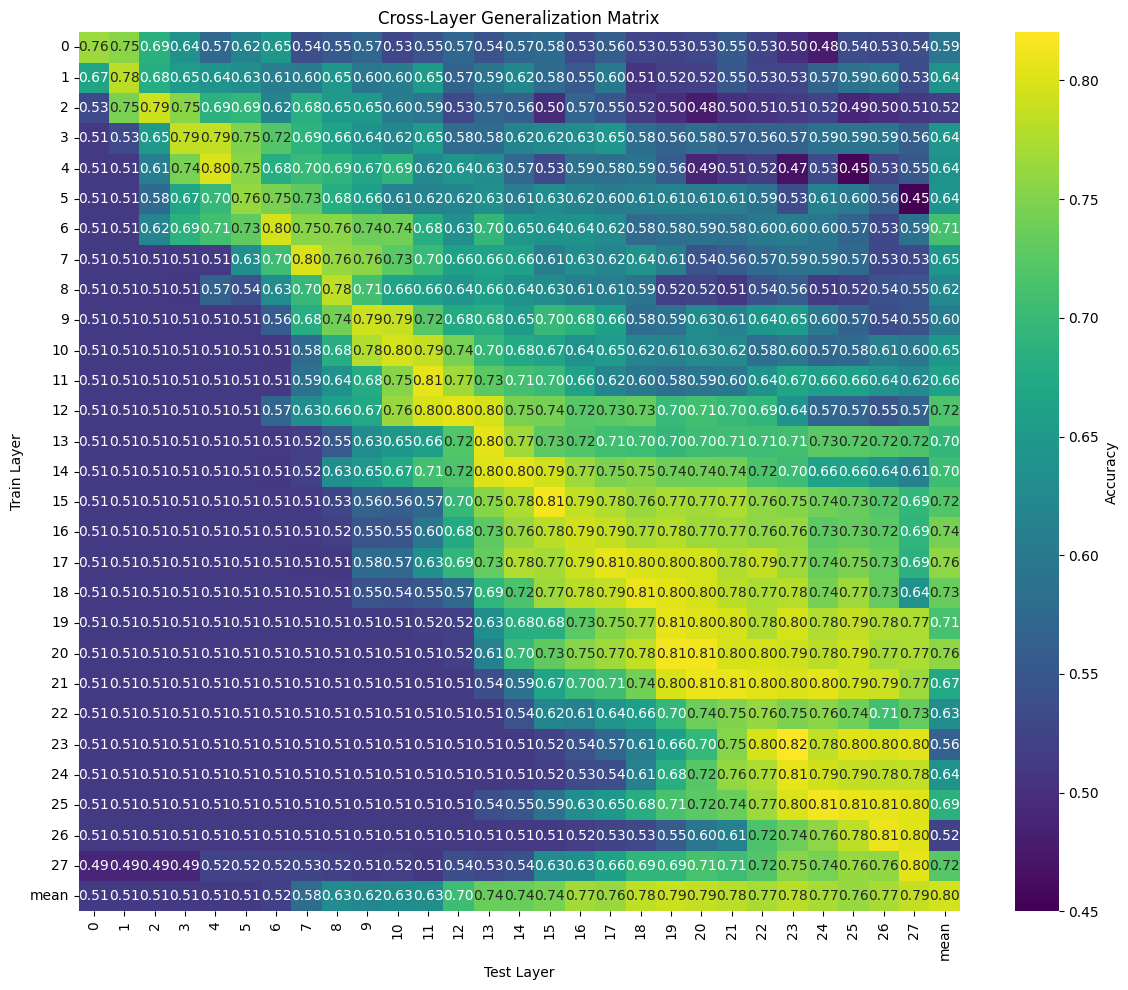

In [20]:
plot_layer_transfer_accuracy(test_accuracies_mlp)